# DATA ANALYSIS NOT ZIP

In [2]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap
import numpy as np
import re
import json
import csv
import matplotlib.pyplot as plt


In [3]:
# model=word2vec.Word2Vec.load('../Data/Models/word2vec_epoch_1000_min_1.model')
#model=word2vec.Word2Vec.load('../Data/Models/best_model.model')
model=word2vec.Word2Vec.load('../Data/Models/best_model_new.model') #dim 300 mange gange med adressesammensmeltning
#model=word2vec.Word2Vec.load('../Data/Models/best_model_100_dim_5e.model')

In [4]:
f = open('../Data/data.json')
data = json.load(f)

a = open('../Data/added_data.json')
added_data = json.load(a)

In [5]:
with open('../Data/sequences.csv', 'r') as f:
    reader = csv.reader(f)
    sequences = list(reader)

In [6]:
X = model.wv.vectors

In [7]:
# tsne
def tsne_plot(X):
    X=np.array(X)
    #pca = PCA(n_components=50)
    #X_pca=pca.fit_transform(X)
    proj = TSNE(perplexity=20).fit_transform(X)
    return proj
proj=tsne_plot(X)

# UMAP 
proj_1 = umap.UMAP(n_components=2, n_neighbors=20, metric='cosine').fit_transform(X)

# pca 
pca = PCA(n_components=2)
proj_2=pca.fit_transform(X)

In [8]:
# pacmap 
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_3 = embedding.fit_transform(X, init="pca")


In [9]:
# Create a dictionary to map addresses to their corresponding embeddings
journey_embeddings = {}
for journey in sequences:
    for place in journey:
        try:
            journey_id = place  # Convert the journey list to a tuple to use as a dictionary key
            journey_embeddings[journey_id] = model.wv[journey_id]
        except KeyError:
            # Handle cases where the journey is not present in the Word2Vec model
            pass

# Convert dictionary to numpy array
X = np.array(list(journey_embeddings.values()))

# Create a list of all addresses
journey_ids = list(journey_embeddings.keys())

embedding 


# Create a dictionary mapping addresses to their index in the numpy array
journey_idx = {journey_id: idx for idx, journey_id in enumerate(journey_ids)}

In [21]:
print(len(journey_ids)) #number of unique locations is 3751

3751



____________________________________________________________________________________________________________________________________________________



















# Plots with count

In [30]:
counts_to_labels = {100: '0-100', 1000: '101-1000', 5000: '1001-5000', 10000: '5001-10000', 50000: '10000-50000', 100000: '50001-100000', 1000001: '100000+'}


In [31]:
address_count_seq = {}
for seq in sequences:
    for place in seq:
        if place in address_count_seq:
            address_count_seq[place] += 1
        else:
            address_count_seq[place] = 1


from collections import Counter

# Count occurrences of each number of mentions of addresses. So counting how many addresses was mentioned once and so on
address_counts = Counter(address_count_seq.values())

# Sort the counts by their keys (number of mentions), in descending order
sorted_counts = sorted(address_counts.items(), key=lambda x: x[0], reverse=True)

In [32]:

address_cluster_count = {}

for address in address_count_seq.keys():
      count = address_count_seq[address]
      if 0 <= count <= 100:
         address_cluster_count[address] = 100
      elif 101 <= count <= 1000:
         address_cluster_count[address] = 1000
      elif 1001 <= count <= 5000:
         address_cluster_count[address] = 5000
      elif 5001 <= count <= 10000:
         address_cluster_count[address] = 10000
      elif 10001 <= count <= 50000:
         address_cluster_count[address] = 50000
      elif 50001 <= count <= 100000:
         address_cluster_count[address] = 100000
      elif 100001 <= count:
         address_cluster_count[address] = 1000001
      else:
         print("address was: ", address)
         address_cluster_count[address] = 0 


In [33]:
from collections import Counter

# Count occurrences of each zip code
count_counts = Counter(address_cluster_count.values())

# Print the zip code counts
for occurrence, count in sorted(count_counts.items()):
    print(f"Count {occurrence}: {count} occurrences")

Count 100: 4063 occurrences
Count 1000: 833 occurrences
Count 5000: 265 occurrences
Count 10000: 57 occurrences
Count 50000: 76 occurrences
Count 100000: 22 occurrences
Count 1000001: 9 occurrences


{100: '#ffe119', 1000: '#f58231', 5000: '#3cb44b', 10000: '#42d4f4', 50000: '#4363d8', 100000: '#f032e6', 1000001: '#e6194b'}


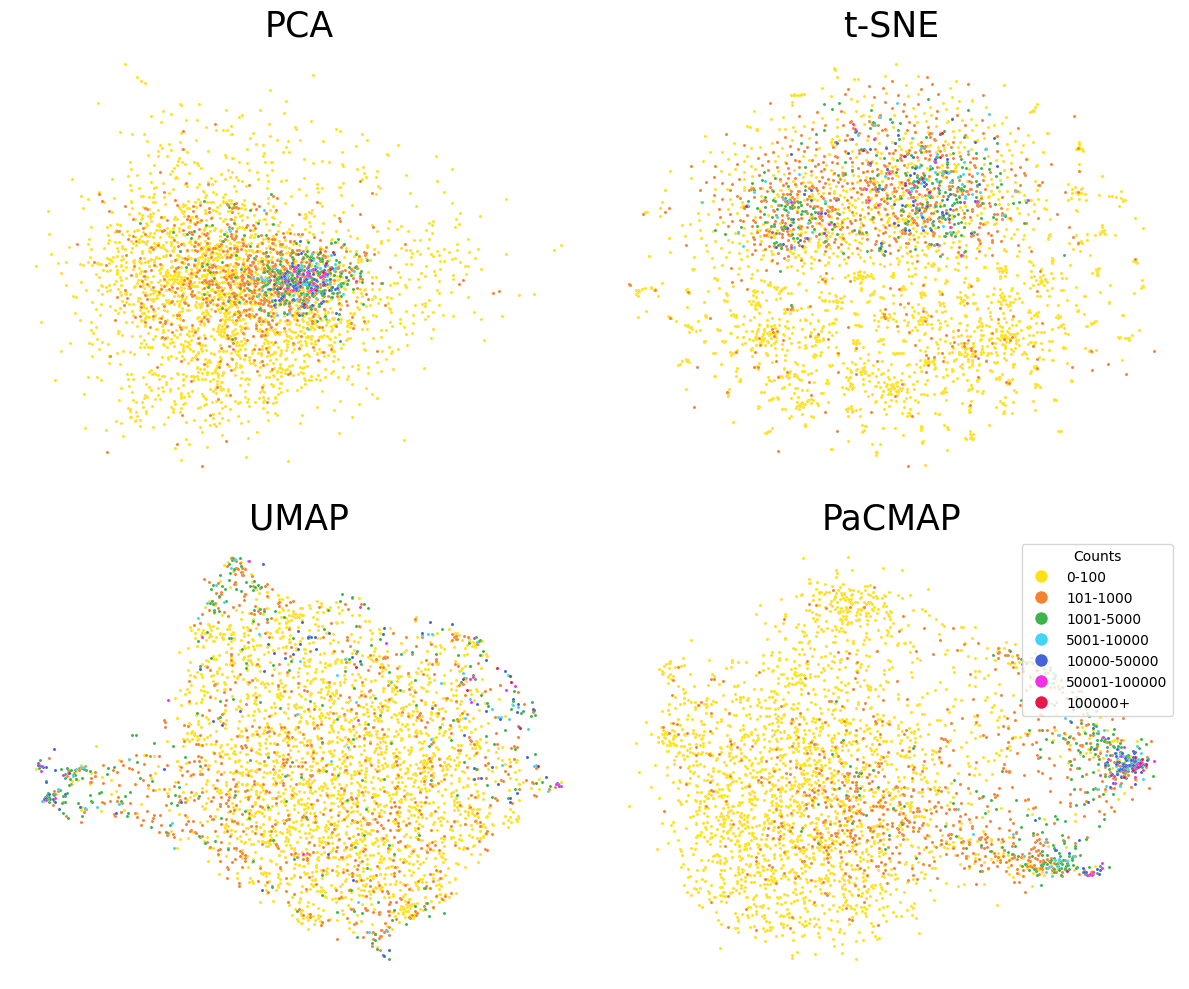

In [37]:

# Define color palette for zip codes
count_colors = {}  # Dictionary to map zip codes to colors
unique_count_codes = sorted(counts_to_labels.keys())
num_colors = len(unique_count_codes) #change this
#color_palette = plt.cm.get_cmap('tab20', num_colors)  # Choose a colormap
color_palette = ['#ffe119', '#f58231', '#3cb44b', '#42d4f4', '#4363d8', '#f032e6', '#e6194b']
#print("number of unique zips: ", num_colors)

for idx, count_code in enumerate(unique_count_codes):
    count_colors[count_code] = color_palette[idx]

print(count_colors)
# Create the plots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
xs = [proj_2, proj, proj_1, proj_3]  # Use xs to select different dimensionality reduction results
ts = ["PCA", "t-SNE", "UMAP", "PaCMAP"]
s = 0

for row in ax:
    for col in row:
        col.set_title(ts[s], fontsize=25)

        for current_count_code in unique_count_codes:
            relevant_addresses = []
            for address, count_code in address_cluster_count.items():
                if address in journey_ids:
                    if current_count_code == count_code:
                        relevant_addresses.append(address)

            relevant_journeys_zip = [journey_id for journey_id in relevant_addresses]
            col.scatter(
                [xs[s][journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip],
                [xs[s][journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip],
                lw=0.1, s=5, edgecolors='white', label=current_count_code, c=count_colors[current_count_code]
            )
        #  # Add labels to stations makes it impossible to read 
        #     for journey_id in relevant_journeys_zip:
        #         x_coord = xs[s][journey_idx[journey_id]][0]
        #         y_coord = xs[s][journey_idx[journey_id]][1]
        #         col.text(x_coord, y_coord, journey_id, fontsize=8)  # Adjust fontsize as needed
            
        s += 1
        col.axis('off')

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=count_colors[count_code], label=counts_to_labels[count_code]) for count_code in unique_count_codes]
plt.legend(handles=handles, title='Counts')

fig.tight_layout()
plt.show()


# Cosine similarity

In [315]:
from sklearn.metrics.pairwise import cosine_similarity


# similarity_matrix[i, j] represents the cosine similarity between station i and station j
embeddings_matrix = X.shape
embeddings_matrix

# # Calculate cosine similarity matrix between station vectors
similarity_matrix = cosine_similarity(X)
similarity_matrix.shape

import numpy as np

highest = -1
for i in similarity_matrix:
    for j in i:
        if similarity_matrix[i][j] > highest:
            highest = similarity_matrix[i][j]
            
print(highest)

# max_similarity_score = np.max(similarity_matrix)
# max_similarity_score
# # Set the diagonal elements of the similarity matrix to a very low value
# np.fill_diagonal(similarity_matrix, -np.inf)  # Set diagonal elements to negative infinity

# # Calculate the maximum similarity score in the updated similarity matrix
# max_similarity_score = np.max(similarity_matrix)

# # Find the indices of the maximum similarity score in the updated matrix
# max_indices = np.argwhere(similarity_matrix == max_similarity_score)

# # Extract the indices of the most similar pair
# most_similar_pair_indices = max_indices[0]

# # Get the station names corresponding to the indices
# station_names = model.wv.index_to_key
# station_i_name = station_names[most_similar_pair_indices[0]]
# station_j_name = station_names[most_similar_pair_indices[1]]

# # Print the names of the two most similar stations
# print(f"The two most similar stations (not the same) are: {station_i_name} and {station_j_name}")


# # X is your numpy array containing the embedding vectors. Each row of X represents a vector in the embedding space.
# # cosine_similarity(X) computes the cosine similarity between all pairs of vectors in X.
# # The resulting similarity_matrix is a symmetric matrix where each element similarity_matrix[i, j] represents the cosine similarity between vectors X[i] and X[j].
# # After calculating the cosine similarity matrix, you can proceed to perform clustering or any other analysis based on the similarity values.

IndexError: arrays used as indices must be of integer (or boolean) type

In [300]:
for seq in sequences:
    if 'Syrefabriksvej' in seq:
        print(seq)

print()

for seq in sequences:
    if 'C.M. Larsens Alle' in seq:
        print(seq)

['Grækenlandsvej', 'Syrefabriksvej']
['Fjelstrupvej', 'Syrefabriksvej']
['Syrefabriksvej', 'Jemtelandsgade']
['Syrefabriksvej', 'Jemtelandsgade']
['Grækenlandsvej', 'Syrefabriksvej']
['Fjelstrupvej', 'Syrefabriksvej']
['Italiensvej', 'Syrefabriksvej']
['Refshaleøen', 'Syrefabriksvej']
['Børsen', 'Syrefabriksvej']
['Skottegården', 'Syrefabriksvej']
['Florensvej', 'Syrefabriksvej']
['Børsen', 'Syrefabriksvej']

['C.M. Larsens Alle', 'Nørreport St.']
['C.M. Larsens Alle', 'Colbjørnsensgade']
['C.M. Larsens Alle', 'Refshaleøen']
['C.M. Larsens Alle', 'Nørreport St.']
['C.M. Larsens Alle', 'Refshaleøen']
['Ørestad St.', 'C.M. Larsens Alle']
['C.M. Larsens Alle', 'København H']
['C.M. Larsens Alle', 'Nørreport St.']
['C.M. Larsens Alle', 'Backersvej']
['C.M. Larsens Alle', 'Kongens Nytorv St. (Metro)']
['C.M. Larsens Alle', 'Sydhavn St.']
['C.M. Larsens Alle', 'Refshaleøen']
['C.M. Larsens Alle', 'Kongens Nytorv St. (Metro)']
['C.M. Larsens Alle', 'Kongens Nytorv St. (Metro)']
['C.M. Larsens

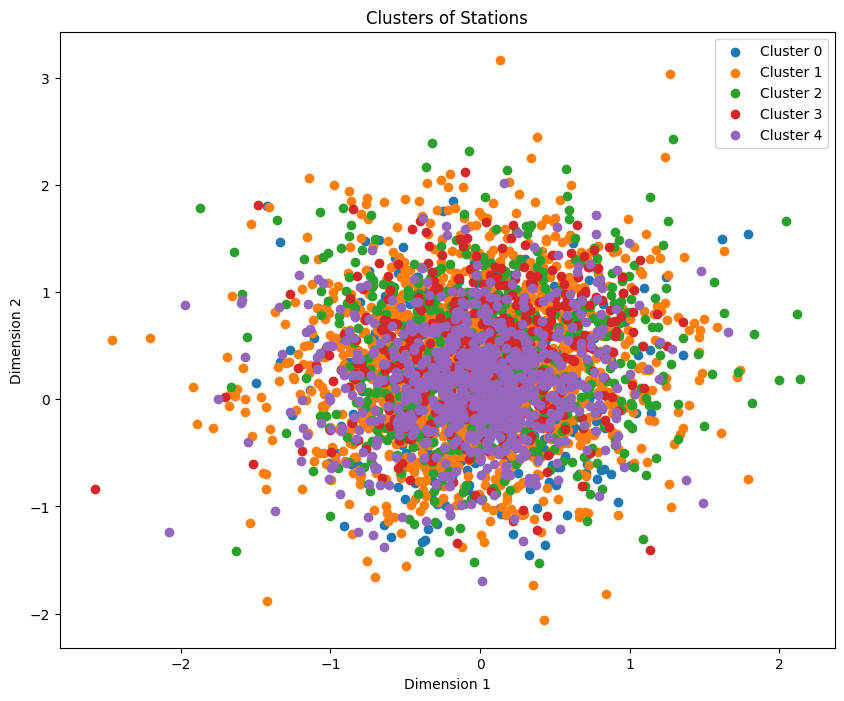

In [277]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming similarity_matrix is the cosine similarity matrix calculated previously

# Define the number of clusters
num_clusters = 5  # Adjust as needed

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(similarity_matrix)

# Plot each station colored by its cluster
plt.figure(figsize=(10, 8))
for cluster_label in range(num_clusters):
    plt.scatter(X[cluster_labels == cluster_label, 0], X[cluster_labels == cluster_label, 1], label=f'Cluster {cluster_label}')

plt.title('Clusters of Stations')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


In [309]:
def find_similar(test): 
    similar_locations=model.wv.most_similar(test, topn=3000)
    for i in similar_locations: 
        print(i)

### København H

In [285]:
from collections import Counter

# Initialize a Counter object to count station occurrences
station_counter = Counter()

# Iterate over sequences and count stations that appear together with 'København H'
for seq in sequences:
    if 'København H' in seq:
        for station in seq:
            # Skip 'København H' itself
            if station != 'København H':
                station_counter[station] += 1

# Print the station counts
for station, count in station_counter.items():
    print(f"{station}: {count} times with 'København H'")

Borrebyvej: 3 times with 'København H'
Hulgårds Plads: 1081 times with 'København H'
Islands Brygge St. (Metro): 1850 times with 'København H'
Drechselsgade: 1278 times with 'København H'
Elmegade: 4803 times with 'København H'
Vesterport St.: 804 times with 'København H'
Nordhavn St.: 8447 times with 'København H'
Nyhavn: 2848 times with 'København H'
Nørreport St.: 15321 times with 'København H'
Peter Bangs Vej St.: 797 times with 'København H'
Trianglen St. (Metro): 9643 times with 'København H'
Wakeup Copenhagen - Borgergade: 239 times with 'København H'
Knippelsbro: 1746 times with 'København H'
Nørrebro St.: 7211 times with 'København H'
Valby St.: 6486 times with 'København H'
Bella Center St. (Metro): 4457 times with 'København H'
Frederiksberg Allé St. (Metro): 2911 times with 'København H'
Brønshøj Torv: 1013 times with 'København H'
Marmorkirken St. (Metro): 11293 times with 'København H'
Nordhavn St. (Metro): 3817 times with 'København H'
Vigerslev Allé: 239 times with 'Køb

In [282]:
find_similar('København H')

('København H (Metro)', 0.4125281572341919)
('Rådhuspladsen', 0.37930673360824585)
('Rådhuspladsen St.', 0.35797086358070374)
('Bernstorffsgade', 0.3288237452507019)
('Vesterport St.', 0.32287493348121643)
('Glyptoteket', 0.31820034980773926)
('Polititorvet', 0.2834121882915497)
('Planetariet', 0.2793344557285309)
('Vesterbrogade', 0.2737449109554291)
('Davids Samling', 0.2718374729156494)


In [283]:
find_similar('CPH Lufthavn')

('Kastrup Tværvej B', 0.3608551621437073)
('Clarion Hotel Copenhagen Airport', 0.3446331322193146)
('Terminalvej Airside', 0.32962140440940857)
('Kastrup St. (Metro)', 0.3076775372028351)
('Vestvej', 0.3003396987915039)
('Kastrup Tværvej F', 0.29943904280662537)
('Ellehammersvej', 0.296190083026886)
('Lufthavnstorvet', 0.2934845983982086)
('Københavns Lufthavn', 0.29071947932243347)
('Terminalgade', 0.29054927825927734)


In [301]:
find_similar('Syrefabriksvej')

('Lærkeskellet', 0.40716251730918884)
('Københavns Museum', 0.3925866186618805)
('Floras Allé', 0.38610130548477173)
('Haveforeningen Uganda', 0.3832564353942871)
('Pelargonievej', 0.34898698329925537)
('Vamdrupvej', 0.34372732043266296)
('Granatvej', 0.34253162145614624)
('Stavlundvej', 0.3381940722465515)
('Slagelse St.', 0.322038859128952)
('Kornerupvej', 0.32150739431381226)


In [310]:
find_similar('C.M. Larsens Alle')

('Hovedstien', 0.36606401205062866)
('Ulspilsager', 0.36487913131713867)
('Ridefogedvej', 0.35542985796928406)
('Hattensens Alle', 0.35270437598228455)
('Arveprinsensvej', 0.35073748230934143)
('Broagergade', 0.34962645173072815)
('Børnehusbroen', 0.34853658080101013)
('Borgskrivervej', 0.34199491143226624)
('Mercur Hotel', 0.3254954516887665)
('Trøjborggade', 0.32223859429359436)
('Vestbirk Alle', 0.31736427545547485)
('Bertel Thorvaldsens Plads', 0.31675413250923157)
('H.C. Ørsted Institutet', 0.3158392310142517)
('Trondhjemsgade', 0.3135645091533661)
('Slotsherrens Have', 0.31352782249450684)
('Krøyers Plads', 0.31331971287727356)
('Asnæsgade', 0.31197190284729004)
('Nordhavn', 0.31132325530052185)
('Onsbjerg Allé', 0.3105435371398926)
('Nordre Digevej', 0.3103382885456085)
('Hotel Euroglobe', 0.309048593044281)
('Blekingegade', 0.30659204721450806)
('Fælledparken', 0.30576789379119873)
('Teglbrændervej', 0.30348291993141174)
('Dybensgade', 0.3034135699272156)
('Brofogedvej', 0.3006